# Sentiment Classification (Binary) on Imdb Review Dataset


In [1]:
# Imports

import sys
import os
import re
import importlib
import numpy as np
from datetime import datetime
from bunch import Bunch
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
from helpers.dataset import Dataset

glove_file = 'C:\\Workspace\\Git\\Data\\glove.6B\\glove.6B.100d.txt'
data_root = 'C:\\Workspace\\Git\\Data\\aclImdb'
categories = ['neg', 'pos']

# Load dataset
ds = Dataset(num_classes=2)
print('[{}] Loading data ...'.format(datetime.now()))
ds.load_dataset_from_dir(os.path.join(data_root, 'train'), os.path.join(data_root, 'test'), categories)

print('[{}] Building vocab and loading glove embeddings ...'.format(datetime.now()))
ds.build_vocab()
ds.load_word_embeddings(glove_file)

print('[{}] Creating X, y sequences ...'.format(datetime.now()))
ds.compute_Xy()

print('[{}] Padding X, y sequences ...'.format(datetime.now()))
ds.pad_Xy(fixed_max_len=30)

[2019-11-10 17:32:16.601195] Loading data ...
[2019-11-10 17:32:24.800883] Building vocab and loading glove embeddings ...
[2019-11-10 17:32:30.109357] Creating X, y sequences ...
[2019-11-10 17:32:32.038186] Padding X, y sequences ...


In [3]:
def print_stats(ds):

    print('Number of Raw Training records: {} examples, {} labels '.format(
        len(ds.raw_train.data), len(ds.raw_train.target)))
    print('Number of Raw Test records: {} examples, {} labels '.format(
        len(ds.raw_test.data), len(ds.raw_test.target)))
    print('Target Names:', ds.raw_train.target_names)

    print('Label distribution in Training Set')
    print(np.asarray(np.unique(ds.raw_train.target, return_counts=True)).T)
    print('Label distribution in Test Set')
    print(np.asarray(np.unique(ds.raw_test.target, return_counts=True)).T)

    print('Vocab Size: ', len(ds.vocab))
    print('shape(word_embeddings): ', ds.word_embeddings.shape)
    print('Top 5 Words in word2index map', ['{}({})'.format(w, i) for w, i in ds.word2index.items() if i <= 5])

    print('shape(ds.X_train) = ', ds.X_train.shape, ' dtype(ds.X_train) = ', ds.X_train.dtype)
    print('shape(ds.y_train) = ', ds.y_train.shape, ' dtype(ds.y_train) = ', ds.y_train.dtype)
    print('shape(ds.X_test) = ', ds.X_test.shape, ' dtype(ds.X_test) = ', ds.X_test.dtype)
    print('shape(ds.y_test) = ', ds.y_test.shape, ' dtype(ds.y_test) = ', ds.y_test.dtype)

    print('Top 5 training examples:')
    for i in range(5):
        print('[#{}]\t {}'.format(i + 1, ds.y_train[i]))
        print('\t', ds.X_train[i][:10])
        print('\t', ' '.join(ds.raw_train.data[i].split()[:30]))
        
print_stats(ds)

Number of Raw Training records: 25000 examples, 25000 labels 
Number of Raw Test records: 25000 examples, 25000 labels 
Target Names: ['neg', 'pos']
Label distribution in Training Set
[[    0 12500]
 [    1 12500]]
Label distribution in Test Set
[[    0 12500]
 [    1 12500]]
Vocab Size:  53858
shape(word_embeddings):  (46197, 100)
Top 5 Words in word2index map ['$PAD$(0)', '$UNK$(1)', 'the(2)', 'of(3)', 'to(4)', 'and(5)']
shape(ds.X_train) =  (25000, 30)  dtype(ds.X_train) =  int64
shape(ds.y_train) =  (25000, 1)  dtype(ds.y_train) =  int32
shape(ds.X_test) =  (25000, 30)  dtype(ds.X_test) =  int64
shape(ds.y_test) =  (25000, 1)  dtype(ds.y_test) =  int32
Top 5 training examples:
[#1]	 [0]
	 [4904  339 2920  339   11    2  174   65    3    2]
	 silent night deadly night is the very last of the series and like part it s unrelated to the first three except by title and the fact that it s
[#2]	 [1]
	 [    2  1072 24523     7   174   595   295    14     7   494]
	 the idea ia a very short

In [4]:
maxN = min(10000, len(ds.X_train)) 
split = int(0.7 * maxN)

offset = 5000

X_train = ds.X_train[offset:offset+split]
y_train = ds.y_train[offset:offset+split]
X_train_seqlen = ds.X_train_seqlen[offset:offset+split]

X_val = ds.X_train[offset+split:offset+maxN]
y_val = ds.y_train[offset+split:offset+maxN]
X_val_seqlen = ds.X_train_seqlen[offset+split:offset+maxN]

word_embeddings = ds.word_embeddings

print('shape(X_train) = ', X_train.shape, ' dtype(X_train) = ', X_train.dtype)
print('shape(y_train) = ', y_train.shape, ' dtype(y_train) = ', y_train.dtype)
print('shape(X_val) = ', X_val.shape, ' dtype(X_val) = ', X_val.dtype)
print('shape(y_val) = ', y_val.shape, ' dtype(y_val) = ', y_val.dtype)
    
print('Label distribution in Training Set')
print(np.asarray(np.unique(y_train, return_counts=True)).T)
print('Label distribution in Validation Set')
print(np.asarray(np.unique(y_val, return_counts=True)).T)

shape(X_train) =  (7000, 30)  dtype(X_train) =  int64
shape(y_train) =  (7000, 1)  dtype(y_train) =  int32
shape(X_val) =  (3000, 30)  dtype(X_val) =  int64
shape(y_val) =  (3000, 1)  dtype(y_val) =  int32
Label distribution in Training Set
[[   0 3532]
 [   1 3468]]
Label distribution in Validation Set
[[   0 1483]
 [   1 1517]]


In [5]:
from helpers.utils import mini_batches
from helpers.evaluate import evaluate_model, predict_instance

class DeepModel:
    
    def __init__(self, model, lr):
        self.model = model
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_op = nn.BCELoss()  # binary cross entropy loss

        self.model.set_optimizer(self.optimizer)
        self.model.set_loss_op(self.loss_op)

        self.epoch_losses = []
        self.epoch_metrics = []
        self.train_losses = []
        self.val_losses = []
        

    def train(self, num_epochs, train_X, train_y, train_X_seqlen, val_X, val_y, val_X_seqlen, epoch_interval_for_lr = 3):
        for epoch in range(num_epochs):

            #X_train, y_train, X_train_seqlen = shuffle(X_train, y_train, X_train_seqlen, random_state=17)
            epoch_loss = self.model.run_epoch(train_X, train_y, train_X_seqlen)

            accuracy1, correct1, total1, loss1 = evaluate_model(self.model, train_X, train_y, train_X_seqlen, self.model.config.batch_size)
            accuracy2, correct2, total2, loss2 = evaluate_model(self.model, val_X, val_y, val_X_seqlen, self.model.config.batch_size)

            self.epoch_losses.append(epoch_loss)
            self.train_losses.append(loss1)
            self.val_losses.append(loss2)
            self.epoch_metrics.append('Training: {:.3f}% (={}/{}) L={:.5f}, Validation: {:.3f}% (={}/{}), L={:.5f}'.format(
                accuracy1, correct1, total1, loss1, accuracy2, correct2, total2, loss2))
            print('Epoch: {}/{}, Loss: {:.8f}, {}'.format(epoch+1, num_epochs, self.epoch_losses[-1], self.epoch_metrics[-1]))

            if (epoch + 1) % epoch_interval_for_lr == 0:
                # reduce learning rate
                for g in self.model.optimizer.param_groups:
                    g['lr'] = g['lr'] / 2                    
                print('Updated Learning Rate = ', set(g['lr'] for g in self.model.optimizer.param_groups))
   

    def plot_loss(self):
        
        plt.plot(self.train_losses)
        plt.plot(self.val_losses)
        plt.title(type(self.model).__name__)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train loss', 'validation loss'], loc='upper right')
        plt.show()

        
    def evaluate(self, test_X, test_y, test_X_seqlen):
        accuracy, correct, total, loss = evaluate_model(self.model, test_X, test_y, test_X_seqlen, self.model.config.batch_size)
        metric = '{:.3f}% (={}/{}) L={:.5f}'.format(accuracy, correct, total, loss)
        print('Test Set Metric: ', metric)
        
        
    def predict(self, ds, input_texts = ['this is a good movie', 'this is worst movie i have seen']):
        for text in input_texts:
            lbl, score = predict_instance(self.model, ds, text)
            print('LABEL = {}, SCORE={:.4f}, INPUT = {}'.format(lbl, score, text))
        

# TextRNN

In [6]:
config = Bunch()
config.vocab_size, config.embed_size = word_embeddings.shape
config.output_size = 1
config.hidden_size = 50
config.num_lstm_layers = 2
config.isBidirectional = True
config.dropout_p = 0.5
config.batch_size = 64
config.lr = 0.001

from helpers.TextRNN import TextRNN

tm = TextRNN(config, torch.from_numpy(word_embeddings).type(torch.FloatTensor))
textRnn = DeepModel(tm, config.lr)

Epoch: 1/10, Loss: 0.68185765, Training: 63.386% (=4437/7000) L=0.64937, Validation: 63.600% (=1908/3000), L=0.65066
Epoch: 2/10, Loss: 0.62330646, Training: 67.886% (=4752/7000) L=0.59023, Validation: 67.300% (=2019/3000), L=0.59576
Epoch: 3/10, Loss: 0.58124931, Training: 68.614% (=4803/7000) L=0.57218, Validation: 67.733% (=2032/3000), L=0.58902
Updated Learning Rate =  {0.0005}
Epoch: 4/10, Loss: 0.55758478, Training: 72.457% (=5072/7000) L=0.53390, Validation: 70.800% (=2124/3000), L=0.55901
Epoch: 5/10, Loss: 0.54313208, Training: 73.443% (=5141/7000) L=0.52166, Validation: 71.000% (=2130/3000), L=0.56324
Epoch: 6/10, Loss: 0.53323843, Training: 74.000% (=5180/7000) L=0.51183, Validation: 70.967% (=2129/3000), L=0.56750
Updated Learning Rate =  {0.00025}
Epoch: 7/10, Loss: 0.51717101, Training: 74.671% (=5227/7000) L=0.49961, Validation: 70.600% (=2118/3000), L=0.56275
Epoch: 8/10, Loss: 0.50678403, Training: 75.100% (=5257/7000) L=0.49166, Validation: 70.367% (=2111/3000), L=0.5

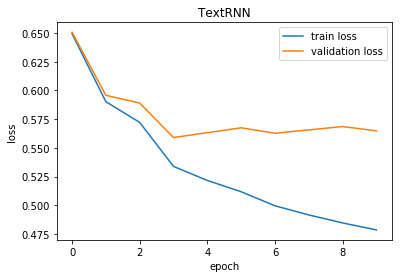

==== EVALUATION ===== 
Test Set Metric:  69.840% (=17460/25000) L=0.56625
==== PREDICT ===== 
LABEL = 1, SCORE=0.8726, INPUT = this is a good movie
LABEL = 0, SCORE=0.0350, INPUT = this is worst movie i have seen


In [7]:
textRnn.train(10, X_train, y_train, X_train_seqlen, X_val, y_val, X_val_seqlen)

textRnn.plot_loss()

print('==== EVALUATION ===== ')
textRnn.evaluate(ds.X_test, ds.y_test, ds.X_test_seqlen)

print('==== PREDICT ===== ')
textRnn.predict(ds)

# TextCNN

In [8]:
config = Bunch()
config.vocab_size, config.embed_size = word_embeddings.shape
config.output_size = 1
config.max_seq_len = 30
config.num_channels = 100
config.kernel_size = [3,4,5]
config.dropout_p = 0.5
config.batch_size = 64
config.lr = 0.001

from helpers.TextCNN import TextCNN

tm = TextCNN(config, torch.from_numpy(word_embeddings).type(torch.FloatTensor))

textCnn = DeepModel(tm, config.lr)

Epoch: 1/10, Loss: 0.66817270, Training: 65.700% (=4599/7000) L=0.60909, Validation: 61.700% (=1851/3000), L=0.63728
Epoch: 2/10, Loss: 0.59428608, Training: 71.429% (=5000/7000) L=0.55120, Validation: 65.867% (=1976/3000), L=0.60792
Epoch: 3/10, Loss: 0.54478901, Training: 77.757% (=5443/7000) L=0.49194, Validation: 69.033% (=2071/3000), L=0.58181
Updated Learning Rate =  {0.0005}
Epoch: 4/10, Loss: 0.49530017, Training: 81.400% (=5698/7000) L=0.44960, Validation: 70.300% (=2109/3000), L=0.57076
Epoch: 5/10, Loss: 0.46872508, Training: 83.357% (=5835/7000) L=0.42090, Validation: 70.633% (=2119/3000), L=0.57204
Epoch: 6/10, Loss: 0.44062760, Training: 84.743% (=5932/7000) L=0.39766, Validation: 69.800% (=2094/3000), L=0.58007
Updated Learning Rate =  {0.00025}
Epoch: 7/10, Loss: 0.40757759, Training: 86.829% (=6078/7000) L=0.36531, Validation: 70.633% (=2119/3000), L=0.56811
Epoch: 8/10, Loss: 0.38618118, Training: 88.543% (=6198/7000) L=0.34488, Validation: 70.967% (=2129/3000), L=0.5

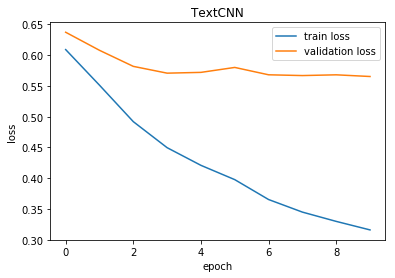

==== EVALUATION ===== 
Test Set Metric:  70.196% (=17549/25000) L=0.56333
==== PREDICT ===== 
LABEL = 1, SCORE=0.6811, INPUT = this is a good movie
LABEL = 0, SCORE=0.0209, INPUT = this is worst movie i have seen


In [9]:
textCnn.train(10, X_train, y_train, X_train_seqlen, X_val, y_val, X_val_seqlen)

textCnn.plot_loss()

print('==== EVALUATION ===== ')
textCnn.evaluate(ds.X_test, ds.y_test, ds.X_test_seqlen)

print('==== PREDICT ===== ')
textCnn.predict(ds)

# Play with Toy Data

In [10]:
## Understand Operations

word_emb = torch.tensor([
    [0,0,0,0,0],
    [1,1,1,1,1],
    [2,2,2,2,2],
    [3,3,3,3,3],
    [4,4,4,4,4],
    [5,5,5,5,5],
    [6,6,6,6,6],
    [7,7,7,7,7],
    [8,8,8,8,8]]).type(torch.FloatTensor)

embeddings = nn.Embedding(num_embeddings=9, embedding_dim=5, padding_idx=0)   # V * d
embeddings.weight = nn.Parameter(word_emb, requires_grad=False)

lstm = nn.LSTM(input_size=5, hidden_size=7, num_layers=2, batch_first=True, bidirectional=True)

X = torch.tensor([[2,3,4],[6,7,0]]).type(torch.LongTensor)

print('X = ')
print(X)
eX = embeddings(X)
print('eX = ')
print(eX)
l_o, (h_n, c_n) = lstm(eX)
print('h_n = ')
print(h_n)
fi = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
print('fi = ')
print(fi)
fv = h_n.view(-1, h_n.size()[0] * h_n.size()[2])
print('fv = ')
print(fv)

X = 
tensor([[2, 3, 4],
        [6, 7, 0]])
eX = 
tensor([[[2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3.],
         [4., 4., 4., 4., 4.]],

        [[6., 6., 6., 6., 6.],
         [7., 7., 7., 7., 7.],
         [0., 0., 0., 0., 0.]]])
h_n = 
tensor([[[ 0.7915, -0.1084, -0.2618,  0.1679,  0.0440, -0.7554, -0.5063],
         [ 0.5276, -0.4043,  0.0175,  0.2580,  0.1024, -0.3890, -0.2707]],

        [[ 0.2485,  0.1212,  0.0561, -0.6016,  0.5162, -0.4252,  0.3071],
         [ 0.1175,  0.0274,  0.0299, -0.7754,  0.6223, -0.1484,  0.1972]],

        [[-0.1246,  0.1081, -0.0599,  0.2184, -0.1115, -0.0730,  0.2251],
         [-0.1479,  0.1668, -0.0972,  0.0909, -0.1165, -0.0078,  0.1779]],

        [[-0.0680, -0.0807, -0.1351, -0.1883, -0.1086,  0.1830,  0.2259],
         [-0.0564, -0.1750, -0.1128, -0.1936, -0.0741,  0.1665,  0.1959]]],
       grad_fn=<StackBackward>)
fi = 
tensor([[ 0.7915, -0.1084, -0.2618,  0.1679,  0.0440, -0.7554, -0.5063,  0.2485,
          0.1212,  0.0561, -0.6016

In [11]:
## Understand Operations

word_emb = torch.tensor([
    [0,0,0,0,0],
    [1,1,1,1,1],
    [2,2,2,2,2],
    [3,3,3,3,3],
    [4,4,4,4,4],
    [5,5,5,5,5],
    [6,6,6,6,6],
    [7,7,7,7,7],
    [8,8,8,8,8]]).type(torch.FloatTensor)

embeddings = nn.Embedding(num_embeddings=9, embedding_dim=5, padding_idx=0)   # V * d
embeddings.weight = nn.Parameter(word_emb, requires_grad=False)

conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(2, 5))
pool1 = nn.MaxPool1d(7-2+1)


X = torch.tensor([[2,3,4,5,6,7,8],[8,7,6,5,4,3,2]]).type(torch.LongTensor)

print('X = ')
print(X)
eX = embeddings(X)
print('eX = ', eX.size())
print(eX)
eX = eX.unsqueeze(1)
print(eX.size())
c1 = conv1(eX).squeeze(3)
print('c1 = ', c1.size())
print(c1)
c1p = pool1(c1).squeeze(2)
print('c1p = ', c1p.size())
print(c1p)

X = 
tensor([[2, 3, 4, 5, 6, 7, 8],
        [8, 7, 6, 5, 4, 3, 2]])
eX =  torch.Size([2, 7, 5])
tensor([[[2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3.],
         [4., 4., 4., 4., 4.],
         [5., 5., 5., 5., 5.],
         [6., 6., 6., 6., 6.],
         [7., 7., 7., 7., 7.],
         [8., 8., 8., 8., 8.]],

        [[8., 8., 8., 8., 8.],
         [7., 7., 7., 7., 7.],
         [6., 6., 6., 6., 6.],
         [5., 5., 5., 5., 5.],
         [4., 4., 4., 4., 4.],
         [3., 3., 3., 3., 3.],
         [2., 2., 2., 2., 2.]]])
torch.Size([2, 1, 7, 5])
c1 =  torch.Size([2, 3, 6])
tensor([[[ 0.0595, -0.0114, -0.0824, -0.1533, -0.2242, -0.2951],
         [-1.6791, -2.2003, -2.7215, -3.2427, -3.7639, -4.2851],
         [-1.4273, -1.8667, -2.3062, -2.7456, -3.1850, -3.6244]],

        [[-0.1622, -0.0913, -0.0203,  0.0506,  0.1215,  0.1924],
         [-3.6962, -3.1750, -2.6538, -2.1326, -1.6114, -1.0902],
         [-3.5852, -3.1458, -2.7063, -2.2669, -1.8275, -1.3881]]],
       grad_fn=<Squ